In [1]:
import os
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datacube

<hr style="border:2px solid gray"> </hr>

# Create dataset

In [2]:
# Create array for wave height
height = xr.DataArray(np.array([[1,2,3],[4,5,6]]), dims=("lat", "lon"), coords={"lat": [1,2], "lon": [1,2,3]})
height.attrs['long_name'] = 'Wave height'
height = height.astype('int16', copy=False)
height

<xarray.DataArray (lat: 2, lon: 3)>
array([[1, 2, 3],
       [4, 5, 6]], dtype=int16)
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) int64 1 2 3
Attributes:
    long_name:  Wave height

In [3]:
# Create array for wave period
period = height.copy(deep=True, data=np.array([[7,8,9],[10,11,12]]))
period.attrs['long_name'] = 'Wave period'  
period = period.astype('int16', copy=False)
period

<xarray.DataArray (lat: 2, lon: 3)>
array([[ 7,  8,  9],
       [10, 11, 12]], dtype=int16)
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) int64 1 2 3
Attributes:
    long_name:  Wave period

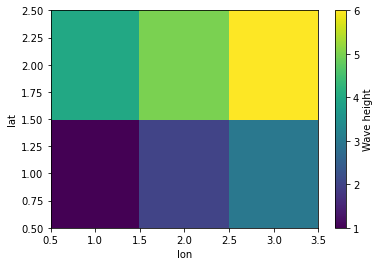

In [4]:
height.plot();

In [5]:
# Create dataset with wave height and period
ds = xr.Dataset({"height": height, "period": period})
#ds.rio.write_crs(4326, inplace=True)
#ds.rio.write_transform(inplace=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 3)
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) int64 1 2 3
Data variables:
    height   (lat, lon) int16 1 2 3 4 5 6
    period   (lat, lon) int16 7 8 9 10 11 12

<hr style="border:2px solid gray"> </hr>

# Save dataset to disk

In [6]:
# Save dataset to netCDF file
file = "minimal-example.nc"
ds.to_netcdf(path=file, mode="w")

In [7]:
# Check file with rio/gdalinfo
#!rio info $file | jq
#!gdalinfo $file

<hr style="border:2px solid gray"> </hr>

# Load dataset from disk

In [10]:
# Load dataset from disk
ds_disk = xr.open_dataset(file)
ds_disk

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 3)
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) int64 1 2 3
Data variables:
    height   (lat, lon) int16 ...
    period   (lat, lon) int16 ...

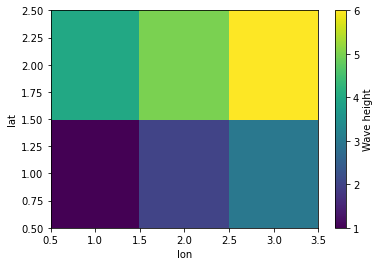

In [11]:
ds_disk.height.plot();

<hr style="border:2px solid gray"> </hr>

# Load dataset from Open Data Cube

In [12]:
# Create datacube instance
dc = datacube.Datacube()

/home/martin/Software/opt/miniconda3/envs/cubeenv/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [13]:
# List available products
product_list = dc.list_products()
product_list

,name,description,dataset_maturity,format,product_type,region_code,instrument,time,lon,lat,platform,creation_time,label,product_family,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,
5,minimal_example_eo,minimal example eo,NaN,NETCDF,minimal_example_eo,NaN,NA,None,None,None,NA,None,None,NaN,EPSG:4326,"(1.0, -1.0)",NaN,"(latitude, longitude)"
6,minimal_example_eo3,minimal example eo3,NaN,None,NaN,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN


In [14]:
# List available datasets/measurements
measurement_list = dc.list_measurements()
measurement_list

name  dtype units  nodata  \
product             measurement                                
minimal_example_eo  height       height  int16     1    -999   
                    period       period  int16     1    -999   
minimal_example_eo3 height       height  int16     1    -999   
                    period       period  int16     1    -999   

                                               aliases  
product             measurement                         
minimal_example_eo  height       [band_01, B01, Band1]  
                    period       [band_02, B02, Band2]  
minimal_example_eo3 height       [band_01, B01, Band1]  
                    period       [band_02, B02, Band2]

In [26]:
# Define parameters
product = "minimal_example_eo"
output_crs = "EPSG:4326"
resolution = (-1, 1)
lon=(1, 3)
lat=(1, 2)

In [27]:
# output_crs and resolution are required for eo3 metadata
ds_datacube = dc.load("minimal_example_eo", 
                      output_crs=output_crs, 
                      resolution=resolution, 
                      latitude=lat, 
                      longitude=lon)
ds_datacube

/home/martin/Software/opt/miniconda3/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/_rio.py:191: DeprecationWarning: Broken/missing geospatial data was found in file:
"NETCDF:"/home/martin/Software/Geo/OpenDataCube/sandbox/github-gist_minimal-example/minimal-example.nc":height"
Will use approximate metadata for backwards compatibility reasons (#673).
This behaviour is deprecated. Future versions will raise an error.
  category=DeprecationWarning)
/home/martin/Software/opt/miniconda3/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/_rio.py:191: DeprecationWarning: Broken/missing geospatial data was found in file:
"NETCDF:"/home/martin/Software/Geo/OpenDataCube/sandbox/github-gist_minimal-example/minimal-example.nc":period"
Will use approximate metadata for backwards compatibility reasons (#673).
This behaviour is deprecated. Future versions will raise an error.
  category=DeprecationWarning)


<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 2, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2021-04-26T14:00:00
  * latitude     (latitude) float64 1.5
  * longitude    (longitude) float64 1.5 2.5
    spatial_ref  int32 4326
Data variables:
    height       (time, latitude, longitude) int16 2 3
    period       (time, latitude, longitude) int16 8 9
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

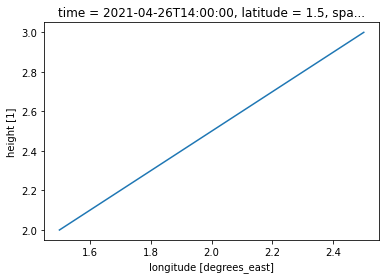

In [28]:
ds_datacube.height.plot();